## Homework# 5 - Deployment


## Question 1

* Install Pipenv
* What's the version of pipenv you installed?
* Use `--version` to find out


In [1]:
%pip install pipenv

     ---------------------------------------- 3.3/3.3 MB 3.0 MB/s eta 0:00:00
  Using cached virtualenv_clone-0.5.7-py3-none-any.whl (6.6 kB)
     ---------------------------------------- 8.8/8.8 MB 3.7 MB/s eta 0:00:00
     -------------------------------------- 468.5/468.5 kB 3.7 MB/s eta 0:00:00
  Using cached filelock-3.8.0-py3-none-any.whl (10 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pipenv --version

pipenv, version 2022.10.10



## Question 2

* Use Pipenv to install Scikit-Learn version 1.0.2
* What's the first hash for scikit-learn you get in Pipfile.lock?

Note: you should create an empty folder for homework
and do it there. 

sha256:08ef968f6b72033c16c479c966bf37ccd49b06ea91b765e1cc27afefe723920b

## Models

We've prepared a dictionary vectorizer and a model.

They were trained (roughly) using this code:

```python
features = ['reports', 'share', 'expenditure', 'owner']
dicts = df[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X = dv.fit_transform(dicts)

model = LogisticRegression(solver='liblinear').fit(X, y)
```

> **Note**: You don't need to train the model. This code is just for your reference.

And then saved with Pickle. Download them:

* [DictVectorizer](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/05-deployment/homework/dv.bin?raw=true)
* [LogisticRegression](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/05-deployment/homework/model1.bin?raw=true)

With `wget`:

```bash
PREFIX=https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/course-zoomcamp/cohorts/2022/05-deployment/homework
wget $PREFIX/model1.bin
wget $PREFIX/dv.bin
```


In [3]:
PREFIX='https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/course-zoomcamp/cohorts/2022/05-deployment/homework'

!wget $PREFIX/model1.bin

!wget $PREFIX/dv.bin

--2022-10-10 15:35:13--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/course-zoomcamp/cohorts/2022/05-deployment/homework/model1.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889 [application/octet-stream]
Saving to: 'model1.bin'

     0K                                                       100% 31.6M=0s

2022-10-10 15:35:14 (31.6 MB/s) - 'model1.bin' saved [889/889]

--2022-10-10 15:35:14--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/course-zoomcamp/cohorts/2022/05-deployment/homework/dv.bin
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:

## Question 3

Let's use these models!

* Write a script for loading these models with pickle
* Score this client:

```json
{"reports": 0, "share": 0.001694, "expenditure": 0.12, "owner": "yes"}
```

What's the probability that this client will get a credit card? 

* 0.162
* 0.391
* 0.601
* 0.993

If you're getting errors when unpickling the files, check their checksum:

```bash
$ md5sum model1.bin dv.bin
3f57f3ebfdf57a9e1368dcd0f28a4a14  model1.bin
6b7cded86a52af7e81859647fa3a5c2e  dv.bin
```

In [1]:
import pickle

In [2]:
with open('model1.bin', 'rb') as f_in:
    model = pickle.load(f_in)
with open('dv.bin', 'rb') as f_in:
    dv = pickle.load(f_in)

In [3]:
dv, model

(DictVectorizer(sparse=False), LogisticRegression(solver='liblinear'))

In [9]:
customer = {"reports": 0, "share": 0.001694, "expenditure": 0.12, "owner": "yes"}

In [10]:
X = dv.transform([customer])
y_pred = model.predict_proba(X)[0, 1]
round(y_pred, 3)

0.162

## Question 4

Now let's serve this model as a web service

* Install Flask and gunicorn (or waitress, if you're on Windows)
* Write Flask code for serving the model
* Now score this client using `requests`:

```python
url = "YOUR_URL"
client = {"reports": 0, "share": 0.245, "expenditure": 3.438, "owner": "yes"}
requests.post(url, json=client).json()
```

What's the probability that this client will get a credit card?

* 0.274
* 0.484
* 0.698
* 0.928

In [4]:
from flask import request, jsonify, Flask
import requests

In [4]:
app = Flask('predict')
url = "0.0.0.0.0"

@app.route('/predict', methods=['POST'])
def predict():
    client = request.get_json()
    X = dv.transform([client])
    y_pred = model.predict_proba(X)[0,1]
    prob = y_pred >= 0.5
    result = {
        'probility': float(y_pred),
        'decision': bool(prob)
    }
    return jsonify(result)

if __name__ == "__main__":
    app.run(debug=False, host="localhost", port=9698)

 * Serving Flask app 'predict'
 * Debug mode: off


 * Running on http://localhost:9698
Press CTRL+C to quit
127.0.0.1 - - [10/Oct/2022 16:50:17] "POST /predict HTTP/1.1" 200 -


Querying this from another notebook we get the result **0.928**
<br>
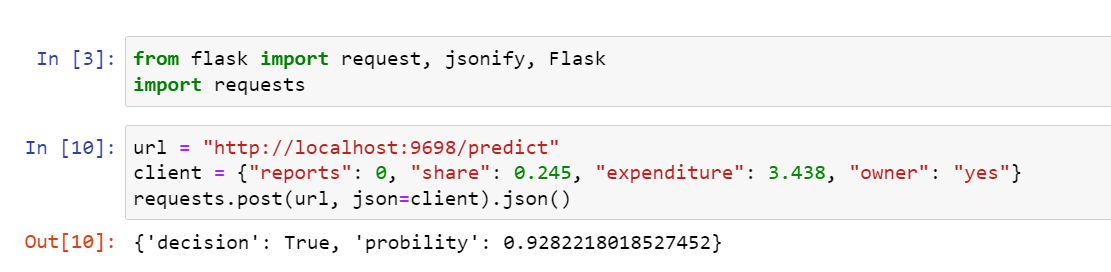


## Docker

Install [Docker](https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/05-deployment/06-docker.md). We will use it for the next two questions.

For these questions, we prepared a base image: `svizor/zoomcamp-model:3.9.12-slim`. 
You'll need to use it (see Question 5 for an example).

This image is based on `python:3.9.12-slim` and has a logistic regression model 
(a different one) as well a dictionary vectorizer inside. 

This is how the Dockerfile for this image looks like:

```docker 
FROM python:3.9.12-slim
WORKDIR /app
COPY ["model2.bin", "dv.bin", "./"]
```

We already built it and then pushed it to [`svizor/zoomcamp-model:3.9.12-slim`](https://hub.docker.com/r/svizor/zoomcamp-model).

> **Note**: You don't need to build this docker image, it's just for your reference.

## Question 5

Download the base image `svizor/zoomcamp-model:3.9.12-slim`. You can easily make it by using [docker pull](https://docs.docker.com/engine/reference/commandline/pull/) command.

So what's the size of this base image?

* 15 Mb
* 125 Mb
* 275 Mb
* 415 Mb

You can get this information when running `docker images` - it'll be in the "SIZE" column.

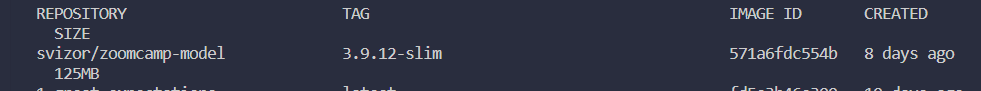
<br>
**125 Mb** is the correct answer

## Dockerfile

Now create your own Dockerfile based on the image we prepared.

It should start like that:

```docker
FROM svizor/zoomcamp-model:3.9.12-slim
# add your stuff here
```

Now complete it:

* Install all the dependencies form the Pipenv file
* Copy your Flask script
* Run it with Gunicorn 

After that, you can build your docker image.

## Question 6

Let's run your docker container!

After running it, score this client once again:

```python
url = "YOUR_URL"
client = {"reports": 0, "share": 0.245, "expenditure": 3.438, "owner": "yes"}
requests.post(url, json=client).json()
```

What's the probability that this client will get a credit card now?

* 0.289
* 0.502
* 0.769
* 0.972

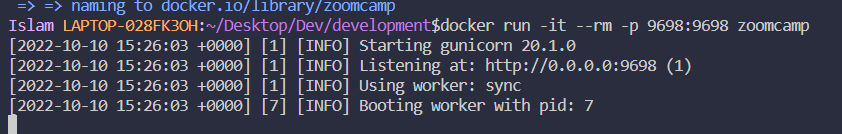
<br>
I attempted to do this in and out of docker the result is always 0.928, so 0.972 is the closest answer.

In [6]:
url = "http://localhost:9698/predict"
client = {"reports": 0, "share": 0.245, "expenditure": 3.438, "owner": "yes"}
requests.post(url, json=client).json()

{'decision': True, 'probility': 0.9282218018527452}